In [3]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import RMSprop, Adam
import numpy as np
import matplotlib.pyplot as plt

### lets create some training data, from the equation 

$$
y_i = \mathcal{F}(x_i) = x_i + \frac{1}{10} \epsilon _i
$$

where $$ \epsilon _i \sim \mathcal{N}(0, 1) $$

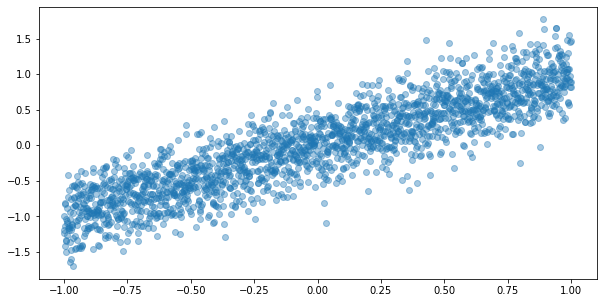

In [5]:
x_train = np.linspace(-1, 1, 2000)[:, np.newaxis]
y_train = x_train + 0.3 * np.random.randn(2000)[:, np.newaxis]

plt.figure(figsize=(10, 5))
plt.scatter(x_train, y_train, alpha=.4)
plt.show()

### now lets create prior and posterior distributions for the weight uncertainty

In [6]:
# prior weight distribution, for this we need to now the number of parameters that is in the layer, i.e., number of kernel weights and biases

def prior(kernel_size, bias_size, dtype=None):
    # number of parameters
    n = kernel_size + bias_size
    prior_model = Sequential([
        tfpl.DistributionLambda( lambda t : tfd.MultivariateNormalDiag( loc=tf.zeros(n), 
                                                                        scale_diag=tf.ones(n) ) )
    ])
    return prior_model


In [7]:
# variational posterior weight distribution, for this we need to now the number of parameters that is in the layer, i.e., number of kernel weights and biases
def posterior(kernel_size, bias_size, dtype=None):
    # number of parameters
    n = kernel_size + bias_size
    posterior_model = Sequential([
        # define trainable variables through the multivariate normal distribution (lower triangular) 
        tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n), dtype=dtype),
        # the trainable layer
        tfpl.MultivariateNormalTriL(n)
    ])
    return posterior_model


In [8]:
# lets define a linear regression model with weight uncertainty: weights are distributed according to posterior and indirectly the prior distribution

model = Sequential([
    # define a dense layer with random kernel and bias. uses variational inference to fit a "surrogate" posterior
    # to the distribution over both the kernl matrix and the bias
    tfpl.DenseVariational(input_shape=(1,),
                           units=1,
                           make_prior_fn=prior,
                           make_posterior_fn=posterior,
                           kl_weight=1/x_train.shape[0],
                           kl_use_exact=True)
])



Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


2022-07-05 12:56:47.726723: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [9]:
model.compile(loss=MeanSquaredError(), optimizer=RMSprop(learning_rate=0.005))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_variational (DenseVar  (None, 1)                5         
 iational)                                                       
                                                                 
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


In [10]:
# fit the model to the data
model.fit(x_train, y_train, epochs=500, verbose=False)

2022-07-05 12:56:49.213094: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [11]:
dummy_input = np.array([[0]])
model_prior = model.layers[0]._prior(dummy_input)
model_posterior = model.layers[0]._posterior(dummy_input)
print('prior mean:                         ', model_prior.mean().numpy())
print('prior variance:                     ', model_prior.variance().numpy())
print('posterior mean:                     ', model_posterior.mean().numpy())
print('posterior covariance:               ', model_posterior.covariance().numpy()[0])
print('                                    ', model_posterior.covariance().numpy()[1])



prior mean:                          [0. 0.]
prior variance:                      [1. 1.]
posterior mean:                      [0.9918581  0.01373461]
posterior covariance:                [ 9.998969e-04 -8.197377e-05]
                                     [-8.1973769e-05  3.1235119e-04]


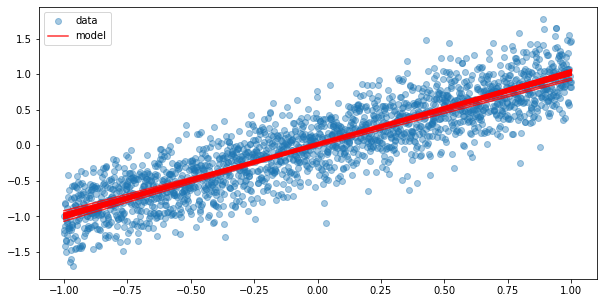

In [12]:
# lets plot the ensemble of linear models

plt.figure(figsize=(10, 5))
plt.scatter(x_train, y_train, alpha=0.4, label='data')
for _ in range(20):
    y_model = model(x_train)
    if _ == 0:
        plt.plot(x_train, y_model, color='red', alpha=0.8, label='model')
    else:
        plt.plot(x_train, y_model, color='red', alpha=0.8)

plt.legend()
plt.show()

# lets test a non-linear, creating training data using the equation

$$
y_i = \mathcal{f}(x_i) = \frac{x_i ^3}{2} + \sqrt{ |x_i| } + \frac{1}{10} x_i \epsilon _i,
$$

where $$ \epsilon _i \sim \mathcal{N}(0, 1) $$

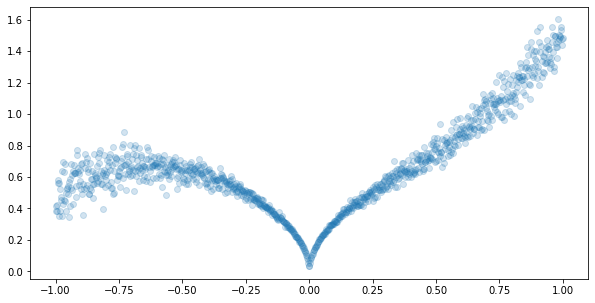

In [13]:
x_train = np.linspace(-1, 1, 1000)[:, np.newaxis]
y_train = 0.5*x_train**3 + np.sqrt( np.abs(x_train) ) +  0.1 * x_train * np.random.randn(1000)[:, np.newaxis]

plt.figure(figsize=(10, 5))
plt.scatter(x_train, y_train, alpha=0.2)
plt.show()


In [32]:
model_nonlin_prob = Sequential([
    tfpl.DenseVariational(units=8,
                          input_shape=(1,),
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/x_train.shape[0],
                          activation='sigmoid'),
    tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/x_train.shape[0],
                          activation='linear'),
    tfpl.IndependentNormal(1)
])

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

In [33]:
model_nonlin_prob.compile(loss=nll, optimizer=Adam(learning_rate=0.001))
model_nonlin_prob.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_variational_7 (DenseV  (None, 8)                152       
 ariational)                                                     
                                                                 
 dense_variational_8 (DenseV  (None, 2)                189       
 ariational)                                                     
                                                                 
 independent_normal_3 (Indep  ((None, 1),              0         
 endentNormal)                (None, 1))                         
                                                                 
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


In [14]:
model_nonlin_prob.fit(x_train, y_train, epochs=15000, batch_size=None, verbose="auto")

Epoch 1/15000


In [ ]:
model_nonlin_prob.evaluate(x_train, y_train)

32/32 [==============================] - 0s 378us/step - loss: -0.9951


-0.9950512647628784

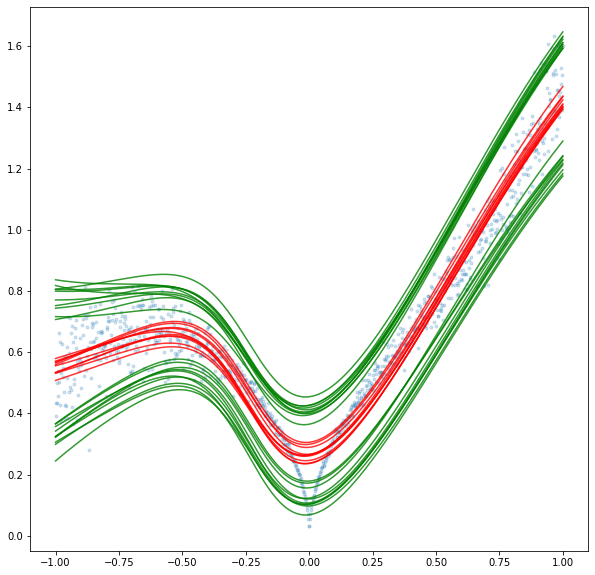

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(x_train, y_train, marker='.', alpha=0.2, label='data')
for _ in range(10):
    y_model = model_nonlin_prob(x_train)
    y_hat = y_model.mean()
    y_hat_m2sd = y_hat - 2 * y_model.stddev()
    y_hat_p2sd = y_hat + 2 * y_model.stddev()
    if _ == 0:
        plt.plot(x_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
        plt.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
        plt.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
    else:
        plt.plot(x_train, y_hat, color='red', alpha=0.8)
        plt.plot(x_train, y_hat_m2sd, color='green', alpha=0.8)
        plt.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
